# **Café Campesino:** 
# *Análisis y Modelamiento de Puntajes de Taza*

Este notebook explora, limpia y modela datos de control de calidad y puntajes de taza de Café Campesino, con el objetivo de identificar patrones y variables relevantes en la calidad del producto con los cuales pueda desarrollarse un modelo predictivo para la calificación de taza.

## Importe de librerías

In [ ]:
import pandas as pd
import re

# --- Modelado y explicabilidad ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

In [269]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Análisis exploratorio de datos
En esta sección se realiza un análisis exploratorio de los datos recolectados durante el proceso de control de calidad del café, abarcando tanto la etapa de trillado como la de tostión. El objetivo principal es comprender la estructura, calidad y características principales de los datos, así como identificar patrones, tendencias y posibles inconsistencias que puedan influir en el modelamiento posterior.

Hemos de notar que para este ejercicio contamos con datos de trillado, tostión y despachos. Entendiendo que el proceso logístico no interviene en la calidad del café, pues es posterior a su evaluación, entonces no se tendrá en cuenta.

**Contexto:**  
El análisis se centra en variables clave del proceso productivo del café, tales como la humedad del grano, la merma durante la tostión, el tamaño de malla, la denominación de origen, la variedad y el puntaje de calidad. Estos datos provienen de registros sistematizados en formatos de control de calidad y permiten caracterizar los lotes procesados en diferentes etapas.

**Definiciones de conceptos clave:**  
- **Humedad:** Porcentaje de agua presente en el grano de café, medido antes y después del proceso de trillado. Es un indicador fundamental para la conservación y calidad del producto.  
- **Merma:** Diferencia porcentual entre el peso del café en verde y el peso después del tostado. Refleja la pérdida de masa debida a la evaporación y otros factores durante la tostión.  
- **Mallas:** Tamaño de los granos de café, determinado mediante tamices estandarizados. Se expresa generalmente en fracciones o números que indican el diámetro del grano.  
- **Denominación:** Código o identificador que agrupa los lotes según su origen geográfico o características particulares.  
- **Variedad:** Tipo genético del café procesado (por ejemplo, Caturra, Colombia, Gesha, etc.), relevante para la trazabilidad y el perfil de taza.  
- **Puntaje:** Calificación sensorial asignada al café tras una cata, que resume atributos de calidad como aroma, sabor, acidez y cuerpo.

A lo largo de esta sección se documentan los pasos de limpieza, transformación y resumen de los datos, sentando las bases para el análisis estadístico y el modelamiento predictivo posterior.

In [270]:
#Función para leer un archivo Excel y concatenar datos de varias hojas
def read_and_concat_data(path:str, sheet_names:list, columns:list, skiprows:int=5):
    df = pd.DataFrame()
    
    for sheet in sheet_names:
        df_temp = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows)
        df_temp.columns = columns  # Asignar nombres de columnas
        df = pd.concat([df, df_temp], ignore_index=True)

    return df


## Lectura de datos de trillado

In [271]:
#Carga del archivo 'Formato de Control de Calidad Café de Trillado.xlsx'

file_path_cc = 'data/Formato de Control de Calidad Café de Trillado.xlsx'

sheet_list_cc = ['CONTROL CALIDAD CAFE TRILLADO J','Sheet2']

columns = ['FECHA', 'LOTE', 'DENOMINACION', 'CANTIDAD', 'HUMEDAD', 'HUMEDAD_C_NC', 'MALLAS', 'MALLAS_C_NC',
       'VERIFICACION_FISICA_CAFE_TOSTADO', 'NOTAS', 'PUNTAJE',
       'PUNTAJE_C_NC', 'LIBERACION_LOTE', 'RESPONSABLE']

df_cc = read_and_concat_data(file_path_cc, sheet_list_cc, columns)

df_cc.head(3)

,FECHA,LOTE,DENOMINACION,CANTIDAD,HUMEDAD,HUMEDAD_C_NC,MALLAS,MALLAS_C_NC,VERIFICACION_FISICA_CAFE_TOSTADO,NOTAS,PUNTAJE,PUNTAJE_C_NC,LIBERACION_LOTE,RESPONSABLE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,%,C/NC,#,C/NC,C/NC,NaN,N°,C/NC,SI/NO,NaN
2,19-07-22,01-190722,Madre Laura,765.0,10.9,C,14,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ


In [272]:

#Eliminar filas con valores nulos en la columna 'DENOMINACION_MARCA' y 'PUNTAJE'
df_cc = df_cc.dropna(subset=['DENOMINACION'])
df_cc = df_cc.dropna(subset=['PUNTAJE'])

## Limpieza en variables numéricas

In [273]:
df_cc['HUMEDAD'] = df_cc['HUMEDAD'].replace(',', '.', regex=True)  # Reemplazar comas por puntos
df_cc['HUMEDAD'] = df_cc['HUMEDAD'].astype(float)
df_cc['HUMEDAD'].describe()

count    106.000000
mean      10.557547
std        0.234195
min       10.000000
25%       10.400000
50%       10.500000
75%       10.800000
max       11.300000
Name: HUMEDAD, dtype: float64

In [274]:
df_cc['PUNTAJE'] = df_cc['PUNTAJE'].replace(',', '.', regex=True).replace(' ','')  # Reemplazar comas por puntos
df_cc['PUNTAJE'] = df_cc['PUNTAJE'].astype(float)
df_cc['PUNTAJE'].describe()

count    106.000000
mean      85.089623
std        1.435597
min       84.000000
25%       84.000000
50%       84.500000
75%       86.000000
max       89.000000
Name: PUNTAJE, dtype: float64

## Codificación de la denominación

In [290]:
# Transformamos la columna 'DENOMINACION' a su equivalente numérico
# Tomamos los primeros 2 caracteres del lote
df_cc['DENOMINACION'] = df_cc['LOTE'].str[:2]

## Limpieza Lote

In [277]:
## Evaluar si el patron de origen es correcto.
## Se listan los lotes que cumplen con el patron de origen
df_cc['LOTE'][~df_cc['LOTE'].str.match(patron, na=False)]

5    07-19-07-22
Name: LOTE, dtype: object

In [275]:
## Trim del campo 'LOTE'
def trim(value):
    if isinstance(value, str):
        return value.strip()
    return value

df_cc['LOTE'] = df_cc['LOTE'].apply(trim)

In [276]:
patron = r'^\d{2}-\d{6}$'

In [278]:
def transform_lote(lote):

    if re.match(patron, lote):
         return lote
    else:
        digits = lote.replace('-','')
        return f'{digits[:2]}-{digits[2:8]}'

In [279]:
df_cc['LOTE'] = df_cc['LOTE'].apply(transform_lote)

In [ ]:
# Verificar nuevamente lotes que no cumplen con el patron de origen
df_cc['LOTE'][~df_cc['LOTE'].str.match(patron, na=False)]

Series([], Name: LOTE, dtype: object)

## Limpieza Fecha

In [281]:
# Filtrar campo Fecha con fechas inválidas
df_cc['FECHA'][pd.to_datetime(df_cc['FECHA'], errors='coerce').isna()]

C:\Users\johanmum\AppData\Local\Temp\ipykernel_29628\1632281365.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cc['FECHA'][pd.to_datetime(df_cc['FECHA'], errors='coerce').isna()]


125      10-Ene-2024
126    02-Abril-2024
Name: FECHA, dtype: object

In [282]:
#Reemplazamos meses en string por números

df_cc['FECHA'] = df_cc['FECHA'].astype(str)  # Nos aseguramos de que la columna sea de tipo string

# Diccionario de mapeo de meses
months_mapping = {'Enero': 1, 'Febrero': 2, 
    'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6, 
    'Julio': 7, 'Agosto': 8,'Septiembre': 9, 
    'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12,
    'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7,
    'Ago': 8, 'Sep': 9, 'Oct': 10,
    'Nov': 11, 'Dic': 12
}

# Reemplazamos los nombres de los meses en la columna 'FECHA'
for nombre_mes in months_mapping:
    df_cc['FECHA'] = df_cc['FECHA'].str.replace(
        nombre_mes, str(months_mapping[nombre_mes]), regex=False)

# Fecha a formato datetime
df_cc['FECHA'] = pd.to_datetime(df_cc['FECHA'], errors='coerce')


C:\Users\johanmum\AppData\Local\Temp\ipykernel_29628\669277603.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cc['FECHA'] = pd.to_datetime(df_cc['FECHA'], errors='coerce')


In [283]:
# Filtrar campo Fecha con fechas inválidas
df_cc['FECHA'][pd.to_datetime(df_cc['FECHA'], errors='coerce').isna()]

Series([], Name: FECHA, dtype: datetime64[ns])

### Fecha auxiliar (desde lote)
Dado que la estructura de la denominación del lote cumple con el formato '', se construye una fecha auxiliar para hacer correcciones sobre la fecha de trillado dada la ocasión en que por cuestiones de formato haya quedado como una fecha anterior a la del lote en cuestión.

Además, se busca hacer una comparativa entre la fecha del lote y la fecha de trillado para evaluar la significancia de la diferencia en el puntaje de taza obtenido, para intentar estimar la entrada de dicha diferencia como una variable numérica en el modelo.

In [284]:
## Fecha desde los último 6 caracteres del lote
def extract_date_from_lote(lote):
    if len(lote) >= 8:
        return pd.to_datetime(lote[-6:], format='%d%m%y', errors='coerce')
    return pd.NaT

In [285]:
df_cc['FECHA_aux'] = df_cc['LOTE'].apply(extract_date_from_lote)

In [286]:
# identificar las fechas menores que la fecha_aux
df_cc['FECHA'][df_cc['FECHA'] < df_cc['FECHA_aux']]

7     2022-02-11
9     2022-04-12
10    2022-04-12
11    2022-04-12
31    2023-02-06
33    2023-04-07
34    2023-04-07
36    2023-02-08
39    2023-08-09
40    2023-08-09
42    2023-08-09
43    2023-04-10
44    2023-04-10
53    2023-11-12
54    2023-11-12
55    2023-11-12
74    2024-03-07
102   2022-03-11
103   2022-10-11
108   2002-12-16
117   2023-01-03
126   2024-02-04
Name: FECHA, dtype: datetime64[ns]

In [287]:
# Se comparar fecha con fecha_aux. Si fecha es menor que fecha_aux,
# entonces se invierte el día y el mes en la fecha original 
# y se toma el año de fecha_aux

df_cc['FECHA'] = df_cc.apply(
    lambda row: pd.to_datetime(
        f"{row['FECHA_aux'].year}-{row['FECHA_aux'].month}-{row['FECHA_aux'].day}"
    ) if (row['FECHA'] < row['FECHA_aux'] or (row['FECHA'] - row['FECHA_aux']).days > 31) else row['FECHA'], axis=1
)

In [288]:
# identificar las fechas menores que la fecha_aux
df_cc['FECHA'][df_cc['FECHA'] < df_cc['FECHA_aux']]

Series([], Name: FECHA, dtype: datetime64[ns])

In [289]:
# diferencia entre fecha y fecha_aux
(df_cc['FECHA'] - df_cc['FECHA_aux']).dt.days[((df_cc['FECHA'] - df_cc['FECHA_aux']).dt.days > 0)]

5      8
6      2
8      1
12     1
13     4
21     1
22    31
24     2
59    31
dtype: int64

Al final del proceso de validación de las diferencias entre fecha de lote y fecha de trillado, se decide no tomar la diferencia como una variable dentro del proceso de modelado dados los pocos registros con diferencia y diferencias poco significativas. Se encuentran registros con 31 días de diferencia, pero se asumen como errores en digitación del mes en la fecha, que dándose una corrección en ese sentido, dejaría la diferencia de fechas en cero (0).

## Set de trillado depurado

In [291]:
#Eliminar columnas redundantes o que no suman información relevante
columns_to_keep = ['LOTE', 'DENOMINACION', 'HUMEDAD', 'MALLAS', 'PUNTAJE']
df_cc = df_cc[columns_to_keep]

#Eliminar duplicados
df_cc = df_cc.drop_duplicates().reset_index(drop=True)

df_cc.head(5)

,LOTE,DENOMINACION,HUMEDAD,MALLAS,PUNTAJE
0,01-190722,01,10.9,14,84.0
1,09-190722,09,10.2,14,85.0
2,10-190722,10,10.7,14,84.5
3,07-190722,07,10.5,14,84.5
4,01-291022,01,10.7,14,84.0


## Lectura y limpieza de datos de tostión

In [292]:
#Carga del archivo 'Formato de Control de Calidad Café de Trillado.xlsx'

file_path_tt = 'data/Formato de Tostión.xlsx'

sheet_list_tt = ['TOSTIÓN JERICÓ L','TOSTIÓN JERICÓ']

columns = ['FECHA', 'LOTE', 'ORIGEN', 'VARIEDAD', 'PROCESO', 'BENEFICIO', 'PESO_EN_VERDE', 'MERMA',
       'PESO_EN_TOSTADO', 'PERFIL', 'TEMPERATURA_INI_FIN',
       'TIEMPO_TUESTE', 'OBSERVACIONES', 'TOSTADOR']

df_tt = read_and_concat_data(file_path_tt, sheet_list_tt, columns)

df_tt.head(3)

,FECHA,LOTE,ORIGEN,VARIEDAD,PROCESO,BENEFICIO,PESO_EN_VERDE,MERMA,PESO_EN_TOSTADO,PERFIL,TEMPERATURA_INI_FIN,TIEMPO_TUESTE,OBSERVACIONES,TOSTADOR
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,175°/191°,08:01:00,NaN,LFQ
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espressso,175°/195°,08:42:00,NaN,LFQ
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,175°/190°,07:58:00,NaN,LFQ


In [293]:
df_tt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FECHA                529 non-null    object 
 1   LOTE                 529 non-null    object 
 2   ORIGEN               529 non-null    object 
 3   VARIEDAD             529 non-null    object 
 4   PROCESO              529 non-null    object 
 5   BENEFICIO            529 non-null    object 
 6   PESO_EN_VERDE        529 non-null    float64
 7   MERMA                529 non-null    float64
 8   PESO_EN_TOSTADO      529 non-null    float64
 9   PERFIL               529 non-null    object 
 10  TEMPERATURA_INI_FIN  529 non-null    object 
 11  TIEMPO_TUESTE        529 non-null    object 
 12  OBSERVACIONES        19 non-null     object 
 13  TOSTADOR             529 non-null    object 
dtypes: float64(3), object(11)
memory usage: 58.0+ KB


In [294]:
# Creámos la columna 'DENOMINACION' a partir de los primeros 2 caracteres del lote
df_tt['DENOMINACION'] = df_tt['LOTE'].str[:2]

In [295]:
# Aplicamos las funciones de trim y transform_lote a la columna 'LOTE'
df_tt['LOTE'] = df_tt['LOTE'].apply(trim)
df_tt['LOTE'] = df_tt['LOTE'].apply(transform_lote)

In [296]:
df_tt['VARIEDAD'].unique()

array(['Dos mil ', 'Tabi ', 'Caturra', 'Gesha ', 'Colombia ',
       'Wush Wush ', 'Pink Bourbon', 'Maragogipe ', 'Castillo',
       'Caturra ', 'Bourbon Rojo ', 'Bourbon Sidra ', 'Red Bourbon ',
       'Caturron '], dtype=object)

In [297]:
dic_variedad = {
    'Dos mil': 'Dos mil', 
    'Tabi': 'Tabi', 
    'Caturra': 'Caturra', 
    'Gesha': 'Gesha', 
    'Colombia': 'Colombia', 
    'Wush Wush': 'Wush Wush',
    'Pink Bourbon': 'Pink Bourbon', 
    'Maragogipe': 'Maragogipe', 
    'Castillo': 'Castillo', 
    'Bourbon Rojo': 'Bourbon Rojo',
    'Bourbon Sidra': 'Bourbon Sidra', 
    'Red Bourbon': 'Bourbon Rojo', 
    'Caturron': 'Caturron',
}

df_tt['VARIEDAD'] = df_tt['VARIEDAD'].apply(trim).replace(dic_variedad)

In [298]:
df_tt['ORIGEN'].str.strip().unique()

array(['Jerico', 'Ciudad Bolivar', 'Herrera', 'Salento', 'Planadas',
       'Herrra', 'Aipe', 'Chaparral', 'Rovira', 'San Antonio', 'Quimbaya',
       'Rioblanco', 'Acevedo'], dtype=object)

In [299]:
dic_origen = {'Jerico': 'Jerico', 
              'Ciudad Bolivar': 'Ciudad Bolivar', 
              'Herrera': 'Herrera', 
              'Salento': 'Salento', 
              'Planadas': 'Planadas',
              'Herrra': 'Herrera', 
              'Aipe': 'Aipe', 
              'Chaparral': 'Chaparral', 
              'Rovira': 'Rovira', 
              'San Antonio': 'San Antonio', 
              'Quimbaya': 'Quimbaya',
              'Rioblanco': 'Rioblanco', 
              'Acevedo': 'Acevedo',
}

df_tt['ORIGEN'] = df_tt['ORIGEN'].apply(trim).replace(dic_origen)

In [300]:
df_tt.head(3)

,FECHA,LOTE,ORIGEN,VARIEDAD,PROCESO,BENEFICIO,PESO_EN_VERDE,MERMA,PESO_EN_TOSTADO,PERFIL,TEMPERATURA_INI_FIN,TIEMPO_TUESTE,OBSERVACIONES,TOSTADOR,DENOMINACION
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,175°/191°,08:01:00,NaN,LFQ,01
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espressso,175°/195°,08:42:00,NaN,LFQ,01
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,175°/190°,07:58:00,NaN,LFQ,01


In [301]:
df_tt_resumen_lote = df_tt.groupby(['LOTE','DENOMINACION']).agg({
    'ORIGEN': 'first',
    'VARIEDAD': 'first',
    'PESO_EN_VERDE': 'sum',
    'PESO_EN_TOSTADO': 'sum'
}).reset_index(
)

df_tt_resumen_origen = df_tt.groupby(['DENOMINACION']).agg({
    'ORIGEN': 'first',
    'VARIEDAD': 'first',
    'PESO_EN_VERDE': 'sum',
    'PESO_EN_TOSTADO': 'sum'
}).reset_index(
)

In [302]:
df_tt_resumen_lote['MERMA'] = (df_tt_resumen_lote['PESO_EN_VERDE'] 
                               - df_tt_resumen_lote['PESO_EN_TOSTADO']
                               )/ df_tt_resumen_lote['PESO_EN_VERDE']

df_tt_resumen_origen['MERMA'] = (df_tt_resumen_origen['PESO_EN_VERDE'] 
                                 - df_tt_resumen_origen['PESO_EN_TOSTADO']
                                 )/ df_tt_resumen_origen['PESO_EN_VERDE']

In [303]:
# Se agregan las columnas 'VARIEDAD' y 'MERMA' al DataFrame df_cc 
df_var_lote = df_cc.merge(df_tt_resumen_lote,
                    on='LOTE', how='left', suffixes=('', '_')
                    )[['LOTE', 'DENOMINACION', 'ORIGEN',  'VARIEDAD', 'MERMA']]

df_var_origen = df_cc.merge(df_tt_resumen_origen,
                    on='DENOMINACION', how='left', suffixes=('', '_')
                    )[['LOTE', 'DENOMINACION', 'ORIGEN', 'VARIEDAD', 'MERMA']]

# Se rellena los valores nulos de 'ORIGEN', 'VARIEDAD' y 'MERMA' con los valores de df_tt_resumen_origen
df_cc['ORIGEN'] = df_var_lote['ORIGEN'].fillna(df_var_origen['ORIGEN'])
df_cc['VARIEDAD'] = df_var_lote['VARIEDAD'].fillna(df_var_origen['VARIEDAD'])
df_cc['MERMA'] = df_var_lote['MERMA'].fillna(df_var_origen['MERMA'])

df_cc.head(3)

,LOTE,DENOMINACION,HUMEDAD,MALLAS,PUNTAJE,ORIGEN,VARIEDAD,MERMA
0,01-190722,01,10.9,14,84.0,Jerico,Dos mil,0.171277
1,09-190722,09,10.2,14,85.0,Ciudad Bolivar,Tabi,0.170355
2,10-190722,10,10.7,14,84.5,Jerico,Caturra,0.169200


# Modelamiento

### Definición del set de datos a utilizar

In [304]:
# Set de datos final
model_columns = ['ORIGEN', 'VARIEDAD', 'HUMEDAD', 'MALLAS', 'MERMA', 'PUNTAJE']

dataset = df_cc[model_columns].copy()

dataset.head(3)

,ORIGEN,VARIEDAD,HUMEDAD,MALLAS,MERMA,PUNTAJE
0,Jerico,Dos mil,10.9,14,0.171277,84.0
1,Ciudad Bolivar,Tabi,10.2,14,0.170355,85.0
2,Jerico,Caturra,10.7,14,0.169200,84.5


### Definición del preprocesamiento

In [305]:
# (I) Preprocesamiento
cat_features = ['ORIGEN', 'VARIEDAD']
num_features = ['HUMEDAD', 'MALLAS', 'MERMA']

X = dataset.drop('PUNTAJE', axis=1)
y = dataset['PUNTAJE']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# (II) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# (III) Modelos y búsqueda de hiperparámetros
def evaluar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    return {
        'rmse': root_mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }

# Diccionario para almacenar resultados
resultados = {}

### Entrenamiento de modelos y evaluación de métricas

In [306]:
# Función para evaluar en train y test
def evaluar_modelo_completo(modelo, X_train, y_train, X_test, y_test):
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    return {
        'rmse_train': root_mean_squared_error(y_train, y_pred_train),
        'mae_train': mean_absolute_error(y_train, y_pred_train),
        'r2_train': r2_score(y_train, y_pred_train),
        'rmse_test': root_mean_squared_error(y_test, y_pred_test),
        'mae_test': mean_absolute_error(y_test, y_pred_test),
        'r2_test': r2_score(y_test, y_pred_test),
        'modelo': modelo
    }

# 1. Regresión Lineal
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('reg', LinearRegression())
])
pipe_lr.fit(X_train, y_train)
resultados['LinearRegression'] = evaluar_modelo_completo(pipe_lr, X_train, y_train, X_test, y_test)

# 2. Árbol de Decisión
param_dt = {'reg__max_depth': [3, 5, 10, None]}
pipe_dt = Pipeline([
    ('pre', preprocessor),
    ('reg', DecisionTreeRegressor(random_state=42))
])
gs_dt = GridSearchCV(pipe_dt, param_dt, cv=5, scoring='neg_root_mean_squared_error')
gs_dt.fit(X_train, y_train)
resultados['DecisionTree'] = evaluar_modelo_completo(gs_dt.best_estimator_, X_train, y_train, X_test, y_test)

# 3. Random Forest
param_rf = {'reg__n_estimators': [50, 100], 'reg__max_depth': [3, 5, 10, None]}
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('reg', RandomForestRegressor(random_state=42))
])
gs_rf = GridSearchCV(pipe_rf, param_rf, cv=5, scoring='neg_root_mean_squared_error')
gs_rf.fit(X_train, y_train)
resultados['RandomForest'] = evaluar_modelo_completo(gs_rf.best_estimator_, X_train, y_train, X_test, y_test)

# 4. XGBoost
param_xgb = {'reg__n_estimators': [50, 100], 'reg__max_depth': [3, 5, 10]}
pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('reg', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
])
gs_xgb = GridSearchCV(pipe_xgb, param_xgb, cv=5, scoring='neg_root_mean_squared_error')
gs_xgb.fit(X_train, y_train)
resultados['XGBoost'] = evaluar_modelo_completo(gs_xgb.best_estimator_, X_train, y_train, X_test, y_test)

# Mostrar resultados en DataFrame
metricas = pd.DataFrame(resultados).T[['rmse_train','rmse_test','mae_train','mae_test','r2_train','r2_test']]
print('Métricas de accuracy en train y test:')
display(metricas)

Métricas de accuracy en train y test:


,rmse_train,rmse_test,mae_train,mae_test,r2_train,r2_test
LinearRegression,0.344849,0.415868,0.247811,0.286086,0.939563,0.926096
DecisionTree,0.0,0.449868,0.0,0.214286,1.0,0.913517
RandomForest,0.237408,0.466673,0.1375,0.305238,0.971356,0.906936
XGBoost,0.051611,0.389791,0.032307,0.276977,0.998646,0.935074


### Elección del mejor modelo

In [308]:
# (III) Elección del mejor modelo
print('Resultados de los modelos:')
for nombre, res in resultados.items():
    print(f"{nombre}: RMSE={res['rmse_test']:.3f}, MAE={res['mae_test']:.3f}, R2={res['r2_test']:.3f}")

mejor_modelo_nombre = min(resultados, key=lambda k: resultados[k]['rmse_test'])
mejor_modelo = resultados[mejor_modelo_nombre]['modelo']
print(f"\nMejor modelo: {mejor_modelo_nombre}")

Resultados de los modelos:
LinearRegression: RMSE=0.416, MAE=0.286, R2=0.926
DecisionTree: RMSE=0.450, MAE=0.214, R2=0.914
RandomForest: RMSE=0.467, MAE=0.305, R2=0.907
XGBoost: RMSE=0.390, MAE=0.277, R2=0.935

Mejor modelo: XGBoost


### Explicabilidad con SHAP (solo para modelos de árbol)

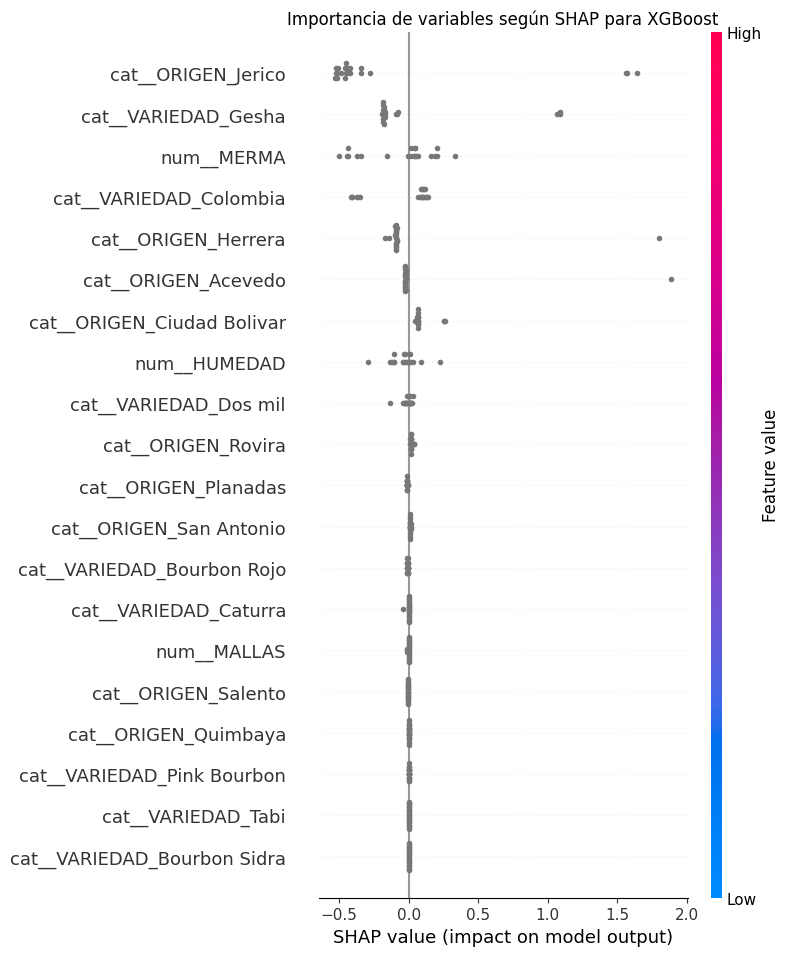

In [309]:
# (IV) Explicabilidad con SHAP (solo para modelos de árbol)
if mejor_modelo_nombre in ['RandomForest', 'XGBoost']:
    # Extraer el modelo y los datos procesados
    X_test_proc = preprocessor.transform(X_test)
    explainer = shap.Explainer(mejor_modelo.named_steps['reg'])
    shap_values = explainer(X_test_proc)
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values, X_test_proc, feature_names=preprocessor.get_feature_names_out(), show=False)
    plt.title(f"Importancia de variables según SHAP para {mejor_modelo_nombre}")
    plt.show()
else:
    print("Explicabilidad SHAP solo implementada para modelos de árbol.")

## Análisis de resultados y conclusiones

Tras implementar y comparar varios modelos de regresión (Regresión Lineal, Árbol de Decisión, Random Forest y XGBoost) para predecir el puntaje de calidad del café, se obtuvieron las siguientes observaciones:

**1. Desempeño de los modelos:**
- Se evaluaron las métricas RMSE, MAE y R² tanto en el conjunto de entrenamiento como en el de prueba para cada modelo. Siendo que el modelo con menor RMSE en test es considerado el mejor para la tarea, ya que indica menor error promedio en la predicción del puntaje, y aún cuando todos los modelos arrojan resultados similares, se elige el modelo XGBoost al tener un mejor rendimiento en esa métrica al evaluarlo con el set de pruebas.
- Se observan diferencia en rendimiento en las métricas de prueba frente al set de datos de entrenamiento y test, lo que podría dar indicios de sobreajuste en algunos modelos. El caso más significativo es el del Árbol de Decisión que en la métrica de R² dio 1, siendo el de mejor resultado, pero frente a observaciones nuevas (test) su rendimiento bajó considerablemente.

**2. Importancia de variables:**
- En el análisis de explicabilidad (SHAP), que muestra qué variables influyen más en la predicción del puntaje, se observa una alta relevancia en variedades y origenes específicos, además de la humedad y la merma que suelen ser relevantes en la calidad del café. En el caso de la denominación de origen, podría ser más significativo para el modelamiento llevarlo no como un categórico, sino extrapolarlo a otras variables como la altura sobre el nivel del mar.

**3. Conclusiones:**
- Si bien el rendimiento entre los modelos implementados no es muy dispar, el modelo seleccionado (según RMSE test) es el más adecuado para predecir el puntaje de taza con los datos y variables disponibles. Esto debe ser reevaluado en contextos con un mayor volúmen de datos, considerando no solo el rendimiento, sino su demanda de recursos.
- El pipeline implementado permite comparar fácilmente nuevos modelos y ajustar hiperparámetros para futuras mejoras.
- Se recomienda seguir recolectando datos y explorar nuevas variables para aumentar la robustez y generalización del modelo. En ello se podría incluir la variable de altura sobre nivel del mar ya sugerida o incluso hacer una exploración de la información dada en el campo 'NOTAS', de la que se podrían extraer las variables de sabor, cuerpo y acidez.

**En resumen:** El proceso permitió identificar el mejor modelo predictivo para el puntaje de café, entender el aporte de cada variable y sentar las bases para un sistema de control de calidad basado en datos.